# Neural Network
In this assignment, you are required to implement a **fully connected neural network** (using NumPy) to perform image classification on the MNIST dataset.

## Set up the environment and data

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Load the MNIST data and flatten it
mnist_dir = "../data/"

from data.mnist import load_from_pickle, load_and_pickle
load_and_pickle(mnist_dir)
data = load_from_pickle(os.path.join(mnist_dir + 'mnist.pkl'))

trainX, trainy = data['trainX'], data['trainy']
testX, testy = data['testX'], data['testy']

trainX = trainX.reshape(len(trainX), -1).astype('int')
testX = testX.reshape(len(testX), -1).astype('int')

## Fully Connected Network
Next, you are first going to design, debug & implement a neural network with fully-connected layers to perform classification using the following "toy data". Following this,  you will test the neural network on the MNIST dataset.

In [2]:
# First, create a small neural network and use the “toy data” below to verify its functionality.
# Note that the random seed is set to ensure that the experiments are repeatable

from network import Net

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return Net(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

### Forward pass: Compute scores
Open the file `network.py` and carefully look at the class method `Net.loss` which uses the data and weights to compute the class scores, the loss, and the gradients. Compute the scores for all inputs in the forward pass using the implementation and then run the cell below to verify your implementation.

In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)

print('\n correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)

# The difference should be very small;  < 1e-7
print('\n Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

 correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

 Difference between your scores and correct scores:
3.6802720745909845e-08


### Forward pass: Compute loss
Complete the second part in the same class method `Net.loss` which computes the data and regularization loss.

In [4]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small; less than 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


### Backward pass
Complete the rest of `Net.loss` (i.e., the backward pass) to compute the gradient of the loss with respect to variables `W1`, `b1`, `W2`, and `b2`. Next, debug your backward pass using the following numeric gradient check:

In [5]:
from gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these differences should be less than 1e-8
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 4.447656e-11
W1 max relative error: 3.561318e-09
b1 max relative error: 2.738421e-09


### Training the network using Stochastic Gradient Descent (SGD)
Complete the missing sections in class methods `Net.train` and `Net.predict` to implement the training and prediction procedures, respectively.

Next, run the code below to train a two-layer network on "toy data". Take note of the training loss, which should be less than 0.2.

Final training loss:  0.01563498761185671


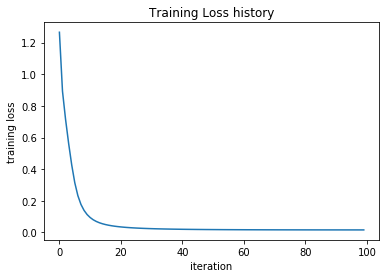

In [6]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

Now that you have now implemented a two-layer network tested using the "toy data", you should next train & test it on a real dataset such as the MNIST data. Run the code below to train your network using SGD and an adaptive learning rate schedule as the optimization proceeds, then test it on a validation set. After each epoch, reduce the learning rate by multiplying it by a decay rate.

In [7]:
X_train, X_val = trainX[:50000], trainX[50000:]
y_train, y_val = trainy[:50000], trainy[50000:]

input_size = 28 * 28
hidden_size = 50
num_classes = 10
net = Net(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=10000, batch_size=128,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 10000: loss 2.302665
iteration 1000 / 10000: loss 0.756872
iteration 2000 / 10000: loss 0.394492
iteration 3000 / 10000: loss 0.319647
iteration 4000 / 10000: loss 0.332465
iteration 5000 / 10000: loss 0.322155
iteration 6000 / 10000: loss 0.282419
iteration 7000 / 10000: loss 0.354267
iteration 8000 / 10000: loss 0.422917
iteration 9000 / 10000: loss 0.310127
Validation accuracy:  0.944


### Tune your network
Complete the code block below to tune your network on the validation set. You may use the cross validation method discussed in Assignment1.

In [29]:
import itertools
import copy
from sklearn.model_selection import KFold
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#################################################################################
# Enter your code
k = 5    # for K-fold cross validation
kf = KFold(n_splits=k)
kf.get_n_splits(trainX)

input_size = 28 * 28
num_classes = 10

best_val_acc = 0
best_param = None
# grid_param = {  
#     'hidden_size': [30, 50, 70],
#     'num_iters': [10000],
#     'batch_size': [64, 128, 256, 1024],
#     'learning_rate': [1e-3, 1e-4, 1e-5],
#     'learning_rate_decay': [0.9, 0.95, 0.99],
#     'reg': [0.1, 0.25, 0.5],   
# }

grid_param = {  
    'hidden_size': [90],
    'num_iters': [10000],
    'batch_size': [256],
    'learning_rate': [2.5e-3],
    'learning_rate_decay': [0.95],
    'reg': [0.1],   
}

keys = grid_param.keys()
values = (grid_param[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]

for param in combinations:
    val_acc = []
    for train_index, test_index in kf.split(trainX):
        X_train, X_val = trainX[train_index], trainX[test_index]
        y_train, y_val = trainy[train_index], trainy[test_index]
        net = Net(input_size, param['hidden_size'], num_classes)
        # Train the network
        stats = net.train(X_train, y_train, X_val, y_val, num_iters=param['num_iters'],
                          batch_size=param['batch_size'], learning_rate=param['learning_rate'],
                          learning_rate_decay=param['learning_rate_decay'], reg=param['reg'])
        # Predict on the validation set
        val_acc.append((net.predict(X_val) == y_val).mean())
    avg_val_acc = sum(val_acc) / k
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        best_net = copy.deepcopy(net)
        best_param = param

print("Best Accuracy: ", best_val_acc)
print(best_param)
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

Best Accuracy:  0.9747166666666667
{'hidden_size': 90, 'num_iters': 10000, 'batch_size': 256, 'learning_rate': 0.0025, 'learning_rate_decay': 0.95, 'reg': 0.1}


### Run on the test set
Finally, evaluate your final trained network on the test set.

In [30]:
test_acc = (best_net.predict(testX) == testy).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.9776
